# PUF Counties Aggregate - Factor Analysis

DeSYNPuf Counties Aggregate with Elixhauser Sums per User & RWJF Factor Rankings Dataset

In [1]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and RWJF County Health Factors and Outcomes Ranking Data from 2010.

2694 out of 3012 counties will be analyzed.

The following rules were applied to transform variables and eliminate outliers before performing this analysis:

1. TOT_VSTS_PB cut >= 20
2. CODES_PU cut >= 25
3. PROCS_PU cut >= 30
4. IPDAYS_PU transformed to square root(IPDAYS_PU), cut >= 4.5 and 0 values transformed to 0.1
5. TOT_CC_INCD cut >= 4.5
6. COST_PB transformed to square root(COST_PB), cut > 520
7. CNTY_IP_PROP cut >= 0.25 and IP_PROP = 1 excluded (2 rows)
8. CNTY_USR_PROP cut <= 0.2

Total counties removed = 179 rows

In [2]:
medicare_counties = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUST_OUTLIERS_REM.csv")
medicare_counties.shape


(2694, 79)

In [3]:
medicare_counties.drop(columns=medicare_counties.columns[0], axis=1, inplace=True, errors="ignore")

In [4]:
medicare_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 78 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FIPS_STATE_CODE         2694 non-null   int64  
 1   FIPS_COUNTY_CODE        2694 non-null   int64  
 2   CNTY_BENE_CT            2694 non-null   int64  
 3   CNTY_BENE_USRS          2694 non-null   int64  
 4   CNTY_MEAN_AGE           2694 non-null   float64
 5   CNTY_SEX_PROP           2694 non-null   float64
 6   TOT_CNCR_CASES          2694 non-null   int64  
 7   TOT_STRKETIA_CASES      2694 non-null   int64  
 8   TOT_ESRD_CASES          2694 non-null   int64  
 9   CNTY_TOT_VSTS           2694 non-null   int64  
 10  CNTY_TOT_IP_VSTS        2694 non-null   int64  
 11  CNTY_TOT_OP_VSTS        2694 non-null   int64  
 12  CNTY_TOT_CODES          2694 non-null   float64
 13  CNTY_TOT_PROCS          2694 non-null   float64
 14  CNTY_MEAN_IP_STAY       2694 non-null   

## Factor Analysis

The purpose of this notebook is to search for Latent Explanatory Variables within the data set.

After examining this angle here, I will try various dimension reduction methods other than PCA in another notebook.

In [5]:
from factor_analyzer import FactorAnalyzer

Prepare for Factor Analysis by subsetting to significant variables, and dropping NULLs.

In [6]:
analysis_ds = medicare_counties[["CNTY_USR_PROP", "TOT_VSTS_PB", "CNTY_IP_PROP",
                                "CODES_PU", "PROCS_PU", "PRVDRS_PU", "SR[TOT_IPDAYS_PU]", "TOT_CC_PREV", 
                                "TOT_CC_INCD", "TOT_ELIX_PU", "SR[TOT_COST_PB]", "HO_PROP_RANK", "HF_PROP_RANK",
                                "DIVERSE_PROP"]]

# I had to rename the columns, because the brackets in the column names were breaking the Bartlett Test
analysis_ds.columns = ["CNTY_USR_PROP", "TOT_VSTS_PB", "CNTY_IP_PROP", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                       "SR_TOT_IPDAYS", "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "SR_TOT_COST_PB", "HO_PROP_RANK",
                      "HF_PROP_RANK", "DIVERSE_PROP"]

analysis_ds = analysis_ds.dropna()
analysis_ds.shape


(2694, 14)

In [7]:
analysis_ds

,CNTY_USR_PROP,TOT_VSTS_PB,CNTY_IP_PROP,CODES_PU,PROCS_PU,PRVDRS_PU,SR_TOT_IPDAYS,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,SR_TOT_COST_PB,HO_PROP_RANK,HF_PROP_RANK,DIVERSE_PROP
0,0.812500,7.000000,0.080357,9.923077,10.487179,2.307692,1.921538,4.937500,2.562500,1.492308,212.555581,0.657,0.851,0.312500
1,0.684211,7.578947,0.076389,12.179487,13.964103,3.297436,2.369680,3.747368,1.705263,1.651029,283.894532,0.955,0.955,0.368421
2,0.857143,6.571429,0.097826,9.000000,9.388889,1.888889,2.198484,3.500000,1.785714,1.791204,258.323717,0.328,0.194,0.500000
3,0.705882,8.941176,0.052632,11.694444,13.833333,2.833333,2.160247,4.470588,2.588235,1.985728,215.654135,0.239,0.716,0.294118
4,0.400000,8.200000,0.048780,19.333333,22.500000,4.500000,1.414214,3.000000,1.400000,0.760913,198.311876,0.060,0.075,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,0.608696,4.434783,0.058824,6.761905,7.976190,1.357143,1.336306,3.086957,1.826087,1.201580,123.855807,0.264,0.278,0.043478
2690,0.882353,8.588235,0.068493,9.922222,12.888889,1.666667,1.949359,4.176471,1.529412,2.069084,226.945186,0.806,0.764,0.058824
2691,0.500000,6.100000,0.054645,11.800000,14.222222,1.422222,1.983263,3.033333,1.233333,1.585815,205.221181,0.819,0.944,0.166667
2692,0.500000,3.750000,0.066667,7.000000,7.666667,1.500000,1.414214,2.750000,0.750000,0.361111,100.079968,0.542,0.236,0.250000


## Bartlett Test for Sphericity

A significant result (low p-value) indicates that a Factor Analysis may be appropriate.

In [8]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(analysis_ds)
chi_square_value, p_value

(25720.379955861372, 0.0)

## Kaiser-Meyer-Olkin (KMO) Test 

This test measures the suitability of the specific variables in the data set, and the model as a whole, for factor analysis. 

It estimates the *proportion of variance* among all the observed variables. 

A lower proportion is more suitable for factor analysis. 

The KMO test values range between 0 and 1. **Value less than 0.6 are considered inadequate**.

In [9]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.769451442404121

In [10]:
kmo_all

array([0.4964308 , 0.73371106, 0.60277325, 0.73216011, 0.86288359,
       0.94858733, 0.8463247 , 0.84553419, 0.85274027, 0.90080541,
       0.91246354, 0.49718292, 0.50595139, 0.82983396])

These results indicate that some of the variables are inadequate.

Specifically, variable 1 (CNTY_USR_PROP), variable 12 (HO_PROP_RANK) and variable 13 (HF_PROP_RANK).  

The other variables are adequate (>.6).  

To remove variables based on the results of the KMO test, we should drop the **lowest value** variable first and re-run the test - removing only one variable at a time.

In [11]:
analysis_ds = analysis_ds.drop("CNTY_USR_PROP", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7919496447443806

In [12]:
kmo_all

array([0.80287097, 0.61373128, 0.80805467, 0.81124001, 0.94406354,
       0.83863742, 0.74600699, 0.81882889, 0.90834227, 0.89415324,
       0.4962333 , 0.50579177, 0.82093249])

Now that we have removed CNTY_USR_PROP, the value of HF_PROP_RANK has improved, but both HO_PROP_RANK and HF_PROP_RANK are still below the 0.6 threshold.

Now, we can remove HO_PROP_RANK.

In [13]:
analysis_ds = analysis_ds.drop("HO_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.8158514383522363

In [14]:
kmo_all

array([0.80298707, 0.61626458, 0.80773001, 0.81115262, 0.94401104,
       0.83822398, 0.74595433, 0.81847102, 0.91141705, 0.8945824 ,
       0.58286794, 0.8295787 ])

The overall KMO for the model is looking very promising!

Since, HF_PROP_RANK is still inadequate, we can remove that as well.

In [15]:
analysis_ds = analysis_ds.drop("HF_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model


0.8163546919892367

In [16]:
kmo_all

array([0.80346385, 0.61658633, 0.80759056, 0.81103716, 0.94397145,
       0.83784378, 0.7465051 , 0.81933433, 0.91188005, 0.89584319,
       0.82952484])

In [17]:
analysis_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694 entries, 0 to 2693
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TOT_VSTS_PB     2694 non-null   float64
 1   CNTY_IP_PROP    2694 non-null   float64
 2   CODES_PU        2694 non-null   float64
 3   PROCS_PU        2694 non-null   float64
 4   PRVDRS_PU       2694 non-null   float64
 5   SR_TOT_IPDAYS   2694 non-null   float64
 6   TOT_CC_PREV     2694 non-null   float64
 7   TOT_CC_INCD     2694 non-null   float64
 8   TOT_ELIX_PU     2694 non-null   float64
 9   SR_TOT_COST_PB  2694 non-null   float64
 10  DIVERSE_PROP    2694 non-null   float64
dtypes: float64(11)
memory usage: 252.6 KB


The final 11 variables look good, and the overall score is excellent!

Now, we can attempt the factor analysis.

Our most meritorious variable is... PRVDRS_PU.

### The final list of variables to be analyzed:

TOT_VSTS_PB   
Total Visits per Beneficiary

CNTY_IP_PROP  
The Proportion of Visits that are Inpatient

CODES_PU      
The Number of Codes per User (A User is a beneficiary with >0 claims for the period (2008-2010))

PROCS_PU      
The Number of Procedures per User (based on HCPCS Level 1 Codes)

PRVDRS_PU     
The Number of Providers per User

SR_IPDAYS_PU 
The Square Root of the Total Number of Inpatient Days per User (for Normalization)

TOT_CC_PREV   
The Total Number of Chronic Conditions / The Number of Beneficiaries in the County

TOT_CC_INCD   
The Total # of New Chronic Conditions during the period / The # of Beneficiaries in the County

TOT_ELIX_PU   
The Sum of all the Avg Elixhauser Scores for all the Users in the County / # of Users 

SR_TOT_COST_PB   
The Square Root of the Total Cost / Number of Beneficiaries in the County (for Normalization)

DIVERSE_PROP  
The Proportion of people in the county whose self-identified race is not white.


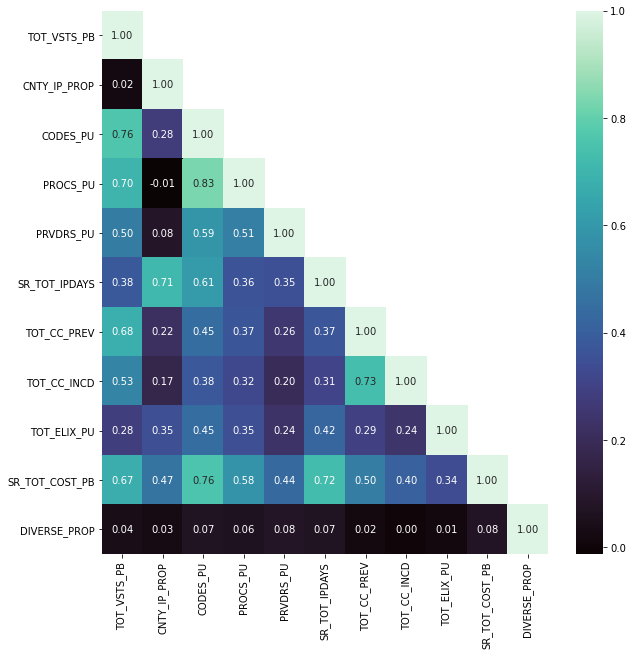

In [18]:
# We can use Pearson correlation now, since we did the work to transform variables and remove outliers!

analysis_corr = analysis_ds.corr(method="pearson")
lower_corr = analysis_corr.where(np.tril(np.ones(analysis_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
analysis_hmap=sb.heatmap(lower_corr, annot=True, cmap="mako", fmt=".2f")
fig = analysis_hmap.get_figure()

fig.savefig("factor_analysis_heatmap.png")

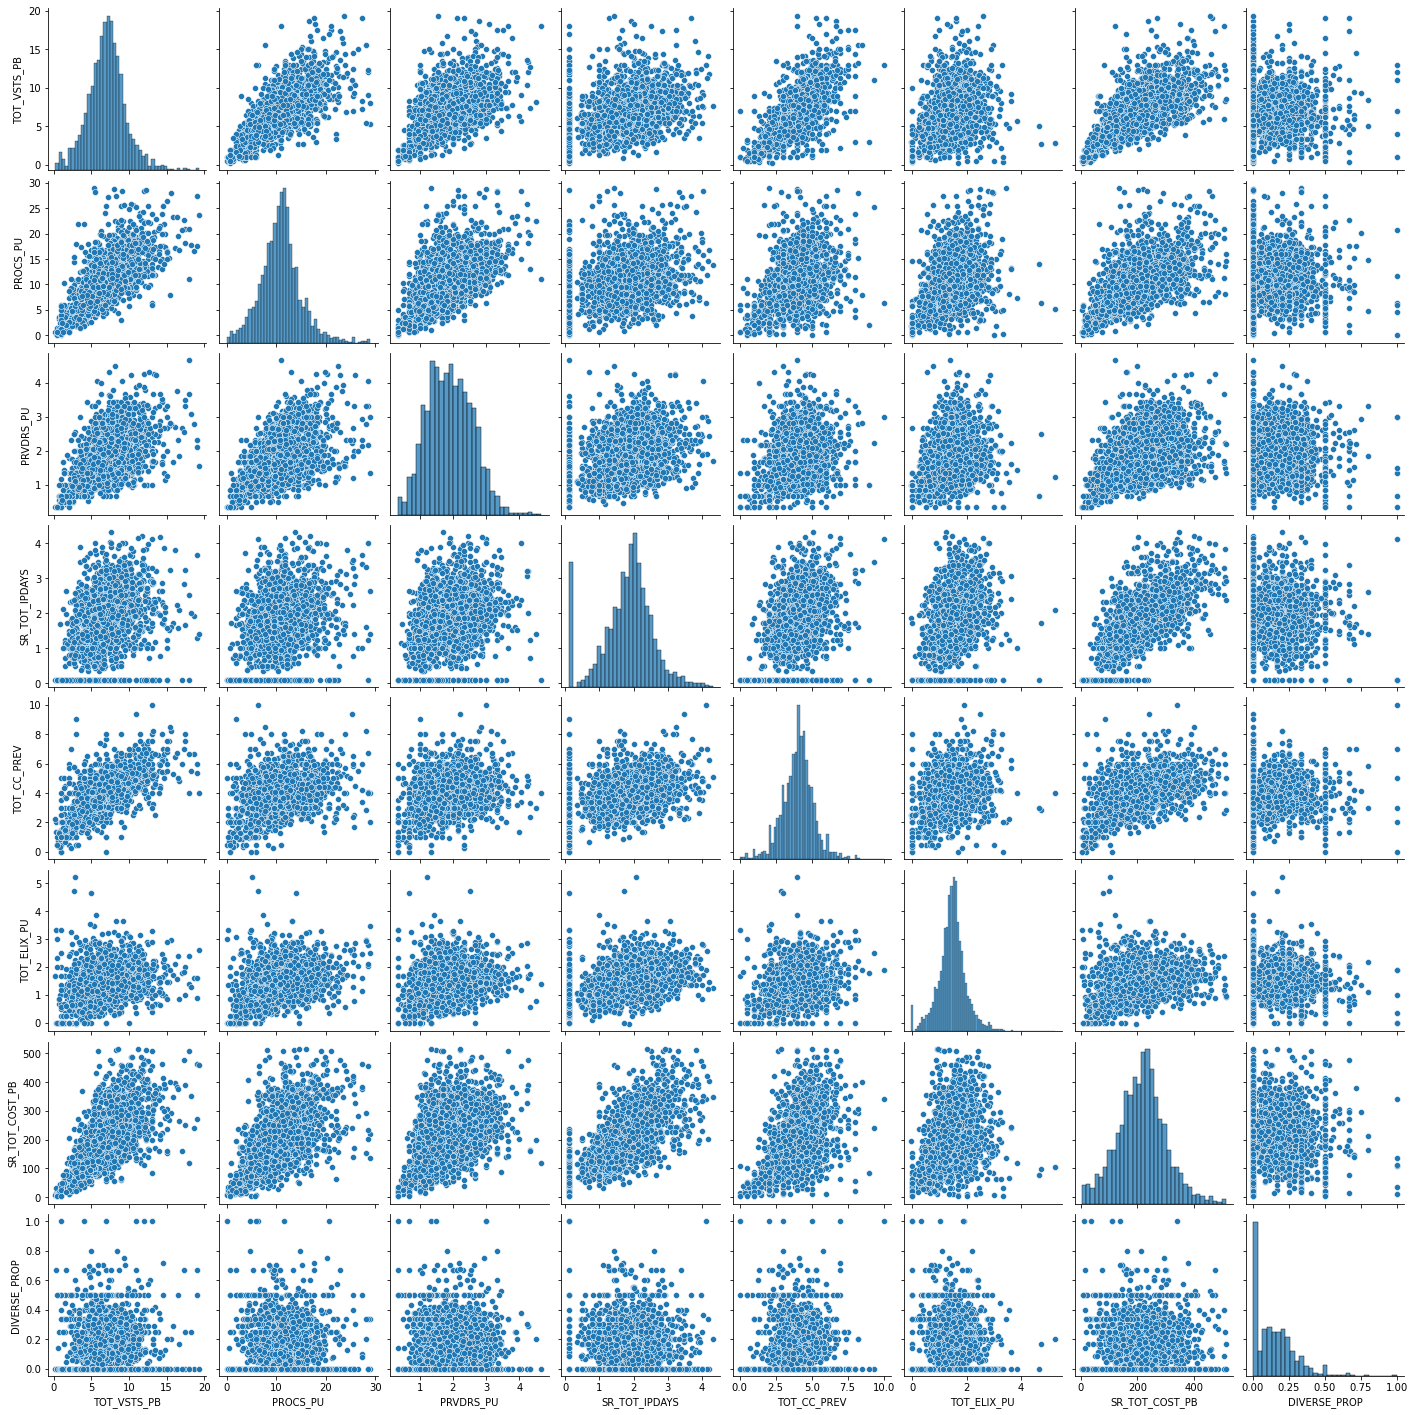

In [19]:
subset1 = analysis_ds[["TOT_VSTS_PB", "PROCS_PU", "PRVDRS_PU", "SR_TOT_IPDAYS", "TOT_CC_PREV", 
                       "TOT_ELIX_PU", "SR_TOT_COST_PB", "DIVERSE_PROP"]]

sb.pairplot(subset1)

In [20]:
# Save a copy before transforming to an np.array

analysis_ds_copy = analysis_ds.copy()

## Standardize the Data

In [21]:
s = pre.StandardScaler()
analysis_ds = s.fit_transform(analysis_ds)

## Kaiser Criterion & Scree Plot

Examining Eigenvalues to determine the number of observable factors (Latent variables).

In [22]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(analysis_ds)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([5.01594373, 1.54389347, 1.20407591, 0.98026792, 0.73857434,
       0.55718104, 0.32180918, 0.22199567, 0.18261197, 0.14737062,
       0.08627615])

There are only 3 eigenvalues > 1, so these would generally be the ones to retain.

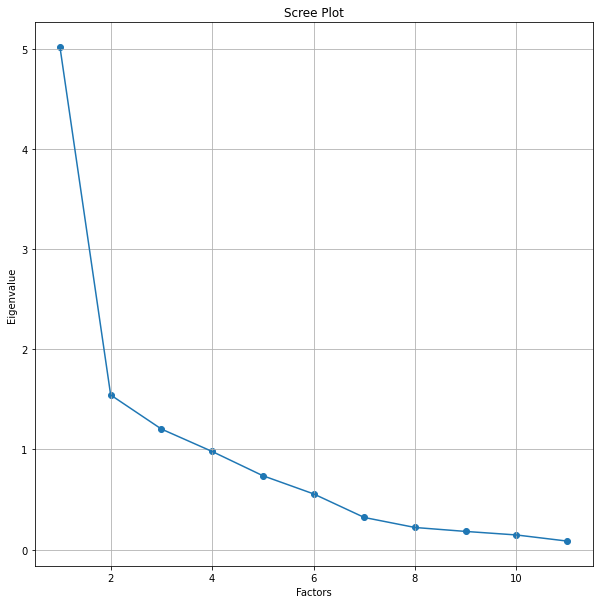

In [23]:
# Create scree plot 
plt.scatter(range(1,analysis_ds.shape[1]+1),ev)
plt.plot(range(1,analysis_ds.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [24]:
fa = FactorAnalyzer(rotation="varimax", n_factors=3)
fa.fit(analysis_ds)
fa.loadings_

array([[ 6.77740314e-01,  6.00486296e-01,  8.98110534e-03],
       [-2.79196678e-02,  6.53911459e-02,  9.28815859e-01],
       [ 8.93878602e-01,  2.70332394e-01,  2.91385692e-01],
       [ 8.35565074e-01,  2.51682241e-01,  8.71005658e-04],
       [ 5.76007779e-01,  1.51989457e-01,  1.04707064e-01],
       [ 3.89893352e-01,  1.90599551e-01,  7.84934757e-01],
       [ 1.52824865e-01,  9.60974766e-01,  1.71059097e-01],
       [ 1.58681537e-01,  7.09573340e-01,  1.42794862e-01],
       [ 3.01017348e-01,  1.82677848e-01,  3.42956649e-01],
       [ 5.96142628e-01,  3.53206440e-01,  4.91982945e-01],
       [ 8.37055671e-02, -1.26631260e-02,  3.90294835e-02]])

In [25]:
analysis_ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694 entries, 0 to 2693
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TOT_VSTS_PB     2694 non-null   float64
 1   CNTY_IP_PROP    2694 non-null   float64
 2   CODES_PU        2694 non-null   float64
 3   PROCS_PU        2694 non-null   float64
 4   PRVDRS_PU       2694 non-null   float64
 5   SR_TOT_IPDAYS   2694 non-null   float64
 6   TOT_CC_PREV     2694 non-null   float64
 7   TOT_CC_INCD     2694 non-null   float64
 8   TOT_ELIX_PU     2694 non-null   float64
 9   SR_TOT_COST_PB  2694 non-null   float64
 10  DIVERSE_PROP    2694 non-null   float64
dtypes: float64(11)
memory usage: 252.6 KB


## Loadings Analysis

**Factor 1** has high factor loadings for TOT_VSTS_PB, CODES_PU, PROCS_PU, PRVDRS_PU, SR_TOT_COST_PB and DIVERSE_PROP.  It has factor loading for TOT_ELIX_PU equal to Factor 3.  It has low loadings for CC_PREV and CC_INCD and it has negative loading for IP_PROP.

**Factor 2** has high factor loadings for TOT_VSTS_PB, IP_PROP, TOT_CC_PREV and TOT_CC_INCD.  It has low to moderate loadings for CODES, PROCS, PRVDRS, SR_TOT_IPDAYS, ELIX_PU, SR_TOT_COST_PB, and negative loading for DIVERSE_PROP.

**Factor 3** has high factor loadings for TOT_VSTS_PB, CNTY_IP_PROP, PROCS_PU, SR_TOT_IPDAYS and SR_TOT_COST_PB. It has factor loading for TOT_ELIX_PU equal to Factor 1.  It has low loadings for CODES, PRVDRS, CC_PREV and CC_INCD.  It has moderate loading for DIVERSE_PROP.

In [26]:
fa.get_communalities()

array([0.81999638, 0.86775441, 0.95700418, 0.7615137 , 0.36584933,
       0.80446759, 0.97608916, 0.54906453, 0.2416019 , 0.72218804,
       0.00869028])

## Communality

The amount of these variables' variance explained by their loading on the factors.

Highest explained: TOT_VSTS_PB, CNTY_IP_PROP, CODES_PU, PROCS_PU, SR_TOT_IPDAYS, TOT_CC_PREV, and SR_TOT_COST_PB

Somewhat explained: TOT_CC_INCD and PRVDRS_PU and TOT_ELIX_PU

In [27]:
fa.get_factor_variance()

(array([2.94264054, 2.1459655 , 1.98561345]),
 array([0.26751278, 0.19508777, 0.18051031]),
 array([0.26751278, 0.46260055, 0.64311086]))

## Factor Variance

First array: Sum of squared loadings (total factor variance)
Second array: Proportional variance of that factor vs. other factors
Third array: Cumulative variance of all factors (from left to right)

The **First Factor** is the most significant, the **Second Factor** is also very significant, and the **Third Factor** is also quite important.

The three factors together account for approximately **64%** of the total variance in these variables!

In [28]:
fa.get_uniquenesses()

array([0.18000362, 0.13224559, 0.04299582, 0.2384863 , 0.63415067,
       0.19553241, 0.02391084, 0.45093547, 0.7583981 , 0.27781196,
       0.99130972])

## Uniquenesses

These variance associated with only a specific varible.

Demographic variables tend to have very high uniqueness of variance - you just can't change your race, sex or age!

In this case, the variables with the most uniqueness of variation were DIVERSE_PROP, PRVDRS_PU, TOT_ELIX_PU.

This suggests these variables "are what they are" and that while they may be influential, they are not easily influenced.

## Can We Describe the Latent Variables / Factors?

## I propose / hypothesize: 

**Factor 1 is our Overutilization Factor.**  It explains / groups counties by Total Visits, Number of Codes, Number of Procedures, Number of Providers and Total Costs.  It has a moderate association with comorbidity, but interestingly, not much association at all with the Number of Chronic Condtions.  It has high association with costs, and with not being white. 

**Factor 2 is our Illness Factor.**  It explains / groups counties by Total Visits, Number of Chronic Conditions, Number of New Chronic Conditions (Incidence). It has the LEAST association with Costs. It has a relationship to the NUMBER of inpatient stays, but not their length. 

**Factor 3 is our Hospitalization Factor.**  It explains / groups counties by Proportion of Inpatient Visits, Number of Codes, and Total Number of Inpatient Days.  It explains a lot of the cost as well, but Factor 1 explains more.  This factor also has moderate association with comorbidity / TOT_ELIX_PU - which could be because counties with higher Elixhauser Scores per User have patients at higher risk for prolonged hospital stays / complications. 

Why is there a slight negative relationship between being not white and Factor 2?  I don't think non-white people in the US are healthier - perhaps it is more that they are not getting diagnosed / labeled with the chronic conditions.  Instead, they are getting hospitalized when things reach critical mass (Factor 3)?  


In [29]:
# Reducing the data set based on the three factors 

df_reduced = fa.fit_transform(analysis_ds)
df_reduced

array([[-0.29548855,  0.82271923,  0.09391919],
       [ 0.92971859, -0.44193193,  0.23580835],
       [-0.18691911, -0.53436542,  0.63097978],
       ...,
       [ 0.94035757, -1.01400954, -0.24972075],
       [-0.64350208, -1.05921202, -0.20397856],
       [-0.22006053, -0.80355168,  0.23238841]])

In [30]:
FACTORS = pd.DataFrame(df_reduced, columns =["FACTORS_1", "FACTORS_2", "FACTORS_3"])


In [31]:
medicare_counties.shape

(2694, 78)

In [32]:
merged = medicare_counties.merge(FACTORS, left_index=True, right_index=True)

In [33]:
merged

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,TSNE_2,TSNE_3,KM_TSNE,FIPS,STATE,COUNTY,CBSA,FACTORS_1,FACTORS_2,FACTORS_3
0,1,1,16,13,65.4,0.187500,3,3,5,112,...,-3.334387,7.042188,0,1001,Alabama,Autauga,33860.0,-0.295489,0.822719,0.093919
1,1,3,95,65,70.3,0.463158,18,8,18,720,...,-1.609500,5.528739,0,1003,Alabama,Baldwin,NaN,0.929719,-0.441932,0.235808
2,1,5,14,12,72.4,0.642857,0,0,4,92,...,-3.519831,-4.749842,1,1005,Alabama,Barbour,NaN,-0.186919,-0.534365,0.630980
3,1,7,17,12,69.0,0.411765,2,3,4,152,...,-6.562319,6.507111,0,1007,Alabama,Bibb,13820.0,0.707499,0.360124,-0.366061
4,1,11,5,2,71.5,0.200000,0,1,2,41,...,-6.472968,2.619024,4,1011,Alabama,Bullock,NaN,3.388853,-1.407649,-0.853064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,55,31,23,14,70.6,0.434783,2,1,3,102,...,-0.417010,-14.107177,2,55031,Wisconsin,Douglas,20260.0,-0.764856,-0.644227,-0.378574
2690,55,33,17,15,73.3,0.470588,4,3,3,146,...,16.800224,-3.217710,3,55033,Wisconsin,Dunn,NaN,0.130767,0.156742,-0.143448
2691,55,35,30,15,72.7,0.366667,0,5,6,183,...,3.867208,-14.988664,2,55035,Wisconsin,Eau Claire,20740.0,0.940358,-1.014010,-0.249721
2692,55,37,4,2,56.8,0.250000,1,1,1,15,...,12.448205,10.743013,3,55037,Wisconsin,Florence,NaN,-0.643502,-1.059212,-0.203979


## Clustering based on Factors

Let's attempt KMeans clustering based on the Factors we have discovered.


In [34]:
merged = merged.drop("KM_FACTORS", axis=1)

from sklearn.cluster import KMeans

k = 5

clustered_df = pd.DataFrame()
kmeans = KMeans(n_clusters=k)
KM_FACTORS = kmeans.fit_predict(FACTORS)
clustered_df["KM_FACTORS"] = KM_FACTORS
clustered_df

,KM_FACTORS
0,3
1,4
2,0
3,3
4,4
...,...
2689,1
2690,3
2691,4
2692,1


In [35]:
merged = merged.iloc[:,0:80]
merged = merged.merge(clustered_df,  left_index=True, right_index=True)
merged.head()

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,TSNE_3,KM_TSNE,FIPS,STATE,COUNTY,CBSA,FACTORS_1,FACTORS_2,FACTORS_3,KM_FACTORS
0,1,1,16,13,65.4,0.187500,3,3,5,112,...,7.042188,0,1001,Alabama,Autauga,33860.0,-0.295489,0.822719,0.093919,3
1,1,3,95,65,70.3,0.463158,18,8,18,720,...,5.528739,0,1003,Alabama,Baldwin,NaN,0.929719,-0.441932,0.235808,4
2,1,5,14,12,72.4,0.642857,0,0,4,92,...,-4.749842,1,1005,Alabama,Barbour,NaN,-0.186919,-0.534365,0.630980,0
3,1,7,17,12,69.0,0.411765,2,3,4,152,...,6.507111,0,1007,Alabama,Bibb,13820.0,0.707499,0.360124,-0.366061,3
4,1,11,5,2,71.5,0.200000,0,1,2,41,...,2.619024,4,1011,Alabama,Bullock,NaN,3.388853,-1.407649,-0.853064,4


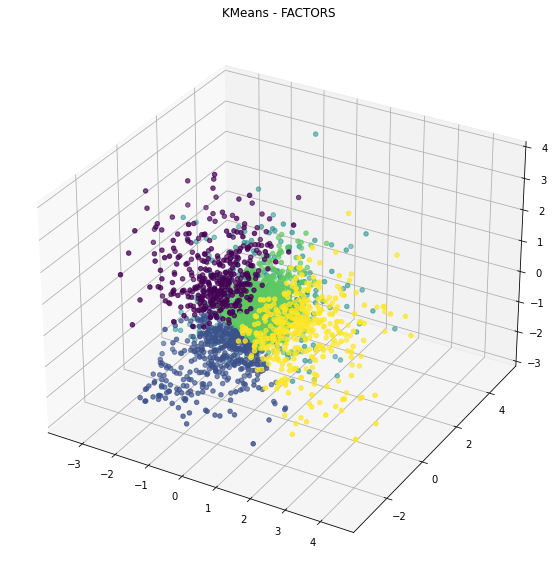

In [36]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
z = merged["FACTORS_3"]
x = merged["FACTORS_1"]
y = merged["FACTORS_2"]
c = merged["KM_FACTORS"]
ax.scatter(x, y, z, c=c)
ax.set_title('KMeans - FACTORS')
plt.show()

In [37]:
merged.to_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUSTERED_NOOUTLIERS.csv")